In [1]:
#--------------------------------------
# Regular, usual inports
#--------------------------------------
import numpy as np
from numpy import arange,array,ones,linalg
import math as m
from matplotlib import cm
from matplotlib import pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

#from __future__ import print_function

from astropy import utils, io
from astropy.io import fits
from astropy.table import Table, vstack, join, Column

#--------------------------------------
# For DBSCAN
#--------------------------------------
from sklearn.cluster import DBSCAN

#--------------------------------------
# For Silhouette
#--------------------------------------
#from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

#--------------------------------------
# For RANSAC
#--------------------------------------
from sklearn import linear_model, datasets

#--------------------------------------
# Datalab and related imports
#--------------------------------------
# need these for authenticating and for issuing database queries
from dl import authClient as ac, queryClient as qc
# need storeClient to use virtual storage or myDB
# Get helpers for various convenience function
from dl import storeClient as sc
from dl.helpers.utils import convert
from getpass import getpass

In [2]:
#--------------------------------------
# Get a token
#--------------------------------------
try:
    input = raw_input
except NameError:
    pass

token = ac.login(input("Enter user name: "),getpass("Enter password: "))

#things to tell you if you got a token or not
if not ac.isValidToken (token):
    print ('nnnnnope (%s)' % token)
else:
    print ("Login token:   %s" % token)

Enter user name: katiefasbender
Enter password: ········
Login token:   katiefasbender.1579.1579.$1$jhF.53l2$51rQiEieDElzi.c.IQw8v1


# Plotting Functions

#### Function to plot DBSCAN results

In [3]:
def plot_dbscan(X,db,pltt,q=[]): #pltt=plt if plotting alone

    labels = db.labels_ #list of object's cluster labels; -1 = outlier
    core_samples_mask = np.zeros_like(labels, dtype=bool) #returns array of zeros of length len(labels)
    core_samples_mask[db.core_sample_indices_] = True #if object is core sample,make it "True" instead of "False"
    unique_labels=set(labels) #unique cluster labels

    # Number of clusters in labels, ignoring noise if present.
    n_clusters = len(unique_labels) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)

    # give each cluster a color, black is removed and used for noise.
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    
    plt.figure(figsize=(10,10))
    
    for k, col in zip(unique_labels, colors):
        class_member_mask = (labels == k)
        mark='o'
         
        if k == -1:
            col = [0, 0, 0, 0]
            mark='.'
        
        xy = X[class_member_mask & ~core_samples_mask]
        pltt.plot(xy[:, 0], xy[:, 1], mark, markerfacecolor=tuple(col),markeredgecolor='k', markersize=6)
        
        xy = X[class_member_mask & core_samples_mask]
        pltt.plot(xy[:, 0], xy[:, 1], mark, markerfacecolor=tuple(col),markeredgecolor=(0,0,0,0.5), markersize=6,label=k)
    
    if q==1:
        pltt.legend(title='Clusters')
    pltt.ticklabel_format(axes='both',useOffset=False)
    
    if pltt==plt:
        pltt.title('%d DBSCAN Clusters,  %d Outliers' % (n_clusters,n_noise))
        plt.xlabel('RA')
        plt.ylabel('DEC')
    else: 
        pltt.set_title('%d DBSCAN Clusters,  %d Outliers' % (n_clusters,n_noise))
        pltt.set_xlabel('RA')
        pltt.set_ylabel('DEC')

#### Function to plot silhouette scores

In [4]:
def plot_s(X,db,q=[]):
    
    label=db.labels_
    n_clusters=len(np.unique(label))
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 9)

# 1st subplot- silhouette plot-------------------------------------------------------------------------------
    # The silhouette coefficient can range from -1, 1 
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, 
    # to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(X,label)
    avg_no_outlier = silhouette_score(X[label!=-1],label[label!=-1])
    print("For n_clusters =", n_clusters,"The average silhouette_score is :", silhouette_avg,
          " including outliers, ",avg_no_outlier," without.")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, label)

    y_lower = 10
    for i in range(-1,n_clusters-1,1):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[label == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i+1) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.8, y_lower + 0.5 * size_cluster_i, str(i))
        if (q==1):  #include silhouette score (ave. silhouette coef.) for each cluster. Only advised for small n_cluster 
            ave=np.mean(silhouette_samples(X, label)[label==i])
            ax1.text(-0.6,y_lower+0.5*size_cluster_i,ave)

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.set_yticks([])  #Clear the yaxis labels / ticks

    ax1.axvline(x=silhouette_avg, color="gray", linestyle="--") #vertical line for average silhouette score
    ax1.axvline(x=avg_no_outlier, color="red", linestyle="--") #vertical line for average silhouette score

# 2nd Plot - showing clusters------------------------------------------------------------------------------------
    colors = cm.nipy_spectral((label.astype(float)+float(1)) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.ticklabel_format(axes='both',useOffset=False)
    ax2.set_xlabel("RA")
    ax2.set_ylabel("DEC")

    plt.suptitle(("Silhouette analysis with n_clusters = %d" % n_clusters), 
                 fontsize=14, fontweight='bold')

    plt.show()

# Analysis Functions

#### Function to run silhouette analysis 

In [5]:
#Find points with low silhouette scores, remove them!
def sil(X,db,outliers,labels,min_score):
    samps=silhouette_samples(X,db.labels_) #silhouette scores for each point
    for i in range(0,max(labels)+1): #for each cluster, except the outliers
        cluster=outliers[db.labels_==i] #define the cluster
        cluster_samps=samps[db.labels_==i] #get the cluster's samps
        for j in cluster_samps: #loop through every point in cluster i, and its score 
            if j<min_score: #if the score is below 0.85,  (this is a cutoff that I thought was good......investigate? Yes.)
                bad=outliers['objectid']==cluster['objectid'][cluster_samps==j] #bad points = ones whose object id 
                                                            #matches the object id of the cluster point with score j
                ind=bad.tolist().index(True) #index of bad points
                outliers[ind]['cluster_label']=-1 #set cluster label of bad points to -1 (cluster label of outliers)
    

#### Function that returns ransac inliers and outliers

Temporal outliers:

In [6]:
def ransac_time(Cluster):
#Format data------------------------------------------------------------------------------
    mjd=np.array(Cluster['ra'])  #I've done RA on the x-axis now because this doesn't handle vertical lines nicely
    X=np.reshape(mjd,(len(mjd),1))
    y=np.array(Cluster['mjd'])

#Here's the dealy = i need this function to get rid of all the points in the cluster if they are not advancing in time.
#So, if X.max()-X.min()=0,
    if y.max()-y.min()==0:
        inlier_mask=np.zeros(len(mjd), dtype=bool)
        outlier_mask=np.ones(len(mjd), dtype=bool)
        clu=Cluster[inlier_mask] #cluster after outlier removal (cluster inliers)
        no=Cluster[outlier_mask] #cluster outliers
        #print("stationary")
        return(clu,no)
    

#Fit SLR using all data------------------------------------------------------------------
    else: 
        lr = linear_model.LinearRegression()
        lr.fit(X, y)

#Robustly fit linear model with RANSAC algorithm-----------------------------------------
        ransac = linear_model.RANSACRegressor(residual_threshold=1)
        ransac.fit(X, y)
        inlier_mask = ransac.inlier_mask_
        outlier_mask = np.logical_not(inlier_mask)

#Define new clusters that don't include the outliers-------------------------------------    
    #print(inlier_mask) #gives array of true = inlier, false = outlier
    #print(Cluster) #cluster before outlier removal
        clu=Cluster[inlier_mask] #cluster after outlier removal (cluster inliers)
        no=Cluster[outlier_mask] #cluster outliers
        #print('moving')
        return(clu,no)

Spacial outliers:

In [7]:
def ransac_space(Cluster):
#Format data------------------------------------------------------------------------------
    mjd=np.array(Cluster['ra'])
    X=np.reshape(mjd,(len(mjd),1))
    y=np.array(Cluster['dec'])

#Fit SLR using all data------------------------------------------------------------------
    lr = linear_model.LinearRegression(.001)
    lr.fit(X, y)

#Robustly fit linear model with RANSAC algorithm-----------------------------------------
    ransac = linear_model.RANSACRegressor()
    ransac.fit(X, y)
    inlier_mask = ransac.inlier_mask_
    outlier_mask = np.logical_not(inlier_mask)

#Define new clusters that don't include the outliers    
    #print(inlier_mask) #gives array of true = inlier, false = outlier
    #print(Cluster) #cluster before outlier removal
    clu=Cluster[inlier_mask] #cluster after outlier removal (cluster inliers)
    no=Cluster[outlier_mask] #cluster outliers
    return(clu,no)

Run both RANSACs:

In [8]:
#Determine invalid points in each cluster and remove, via RANSAC 
def ransac_it(X,db,outliers,labels):
    for i in range(0,max(labels)+1): #for each cluster, except the outliers
        cluster=outliers[db.labels_==i] #define the cluster
    
        #Space
        space=ransac_space(cluster) #ransac on the cluster, test[0] = cluster inliers, test[1] = outliers
        if len(space[1])>0: #If there are outliers,
            for j in range(0,len(space[1])): #for each outlier,
                bad=outliers['objectid']==space[1]['objectid'][j] #bad points = ones whose object id's match the object id's of ransac outliers
                ind=bad.tolist().index(True) #index of bad points
                outliers[ind]['cluster_label']=-1 #set cluster label of bad points to -1 (cluster label of outliers)
   
        #Time
        time=ransac_time(cluster) #ransac on the cluster
        if len(time[1])>0: #If there are outliers,
            for k in range(0,len(time[1])): #for each outlier,
                bad=outliers['objectid']==time[1]['objectid'][k] #bad points = ones whose object id's match the object id's of ransac outliers
                ind=bad.tolist().index(True) #index of bad points
                outliers[ind]['cluster_label']=-1 #set cluster label of bad points to -1 (cluster label of outliers) 

        #Time to figure out if any of the new clusters have fewer than 2 points, because I don't want those!
        #Tracklets need to have 3 or more measurements!
        new=outliers['cluster_label']==i
        new_cluster=outliers[new]
        #print(new_cluster)
        #print('length of cluster = ',len(new_cluster))
        if len(new_cluster)<3:
            for n in range(0,len(new_cluster)):
                test_ind=outliers['objectid'].tolist().index(new_cluster[n]['objectid'])
                #print("test_ind = ",test_ind)
                outliers[test_ind]['cluster_label']=-1

# Query from NSC, then run DBSCAN, RANSAC, and Silhouette analysis on measurements

The following cell has all the code you have to run to cluster the measurements, then validate the clusters.  The only input needed is the (RA,DEC) of the part of the sky you want to analyze. 

In [9]:
%%time
#201.35,-15.74 the regular
#206.35,-18.74 the complex
#6.35,-18.74 with 2 long streaks
#17.35,-1.74 mostly streaks

#Define RA, DEC
RA=201.8
DEC=-15.9
#query from NSC measurements table------------------------------------------------------------------------------------
dat=qc.query(token,sql="".join(["select * from nsc_dr1.meas where q3c_radial_query(ra,dec,",str(RA),",",str(DEC),",.3)"]),fmt='table')
X=np.column_stack((np.array(dat['ra']),np.array(dat['dec'])))  #coordinates of measurements---------------------------

#Compute DBSCAN on all measurements ----------------------------------------------------------------------------------
db_1 = DBSCAN(eps=0.000138889, min_samples=2).fit(X)

#Get outliers from db_1 ----------------------------------------------------------------------------------------------
outliers=db_1.labels_==-1 #define outliers from DBSCAN labels
X_out=np.column_stack((np.array(dat['ra'][outliers]),np.array(dat['dec'][outliers]))) #coordinates of DBSCAN outliers

#Compute DBSCAN on outliers ------------------------------------------------------------------------------------------
db_2 = DBSCAN(eps=.003, min_samples=3).fit(X_out) #min_samples=3 so at least 3 mmts in a tracklet, eps=.001

#Analyze results of db_2 ---------------------------------------------------------------------------------------------
t_out=dat[outliers]#Create table of outliers from db_1
t_out.add_column(Column(db_2.labels_),name="cluster_label") #Add their cluster labels from db_2

lab=np.unique(db_2.labels_) #Identify the unique cluster labels from db_2

sil(X_out,db_2,t_out,lab,0.8) #Silhouette analyze it!
ransac_it(X_out,db_2,t_out,lab) #RANSAC it!

CPU times: user 34 s, sys: 30.2 s, total: 1min 4s
Wall time: 1min 10s


For a (0.785$^{\circ}$)$^2$ area of the sky (search radius = 0.5$^{\circ}$), it takes around 2.5 minutes.

#### Plot clusters before and after validation

This is just a nice visualization of the effects of the validation step.

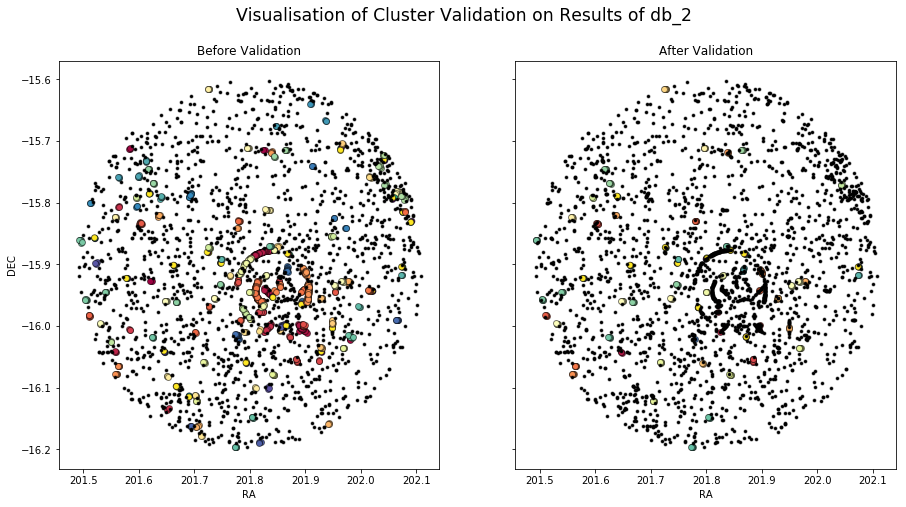

In [10]:
# Define colors------------------------------------------------------------------------------------------------
col_b=[plt.cm.Spectral(each) for each in np.linspace(0, 1, len(np.unique(db_2.labels_)))]
col_a=np.array(col_b)[np.unique(t_out['cluster_label'])+1]
# Plot Results-------------------------------------------------------------------------------------------------
f,(ax1,ax2)= plt.subplots(1, 2,figsize=(15,7.5),sharey=True)
f.suptitle('Visualisation of Cluster Validation on Results of db_2',fontsize='xx-large')
# Figure 1: Before Validation----------------------------------------------------------------------------------
for (i,col) in zip(np.roll(np.unique(db_2.labels_),-1),col_b):
    mark='o'
    if i==-1:
        col=[0,0,0,1]
        mark='.'
    ax1.scatter(t_out['ra'][db_2.labels_==i],t_out['dec'][db_2.labels_==i],label=i,c=tuple(col),
                marker=mark,edgecolors=[0,0,0,0.5])
#ax1.legend(title='Clusters')
ax1.set_xlabel('RA')
ax1.set_ylabel('DEC')
ax1.set_title('Before Validation')
# Figure 2: After Validaiton-----------------------------------------------------------------------------------
for (j,cols) in zip(np.roll(np.unique(t_out['cluster_label']),-1),col_a):
    points=t_out['cluster_label']==j
    mark='o'
    if j==-1:
        mark='.'
        cols=[0,0,0,1]
    ax2.scatter(t_out['ra'][points],t_out['dec'][points],label=j,c=tuple(cols),
                marker=mark,edgecolors=[0,0,0,0.5])
#ax2.legend(title='Clusters')
ax2.set_xlabel('RA')
ax2.set_title('After Validation')
plt.show()

#### Wait a minute what is that

#### Check out the original DBSCAN results

Again, just a visualization of what the 2 iterations of DBSCAN does to the measurements.

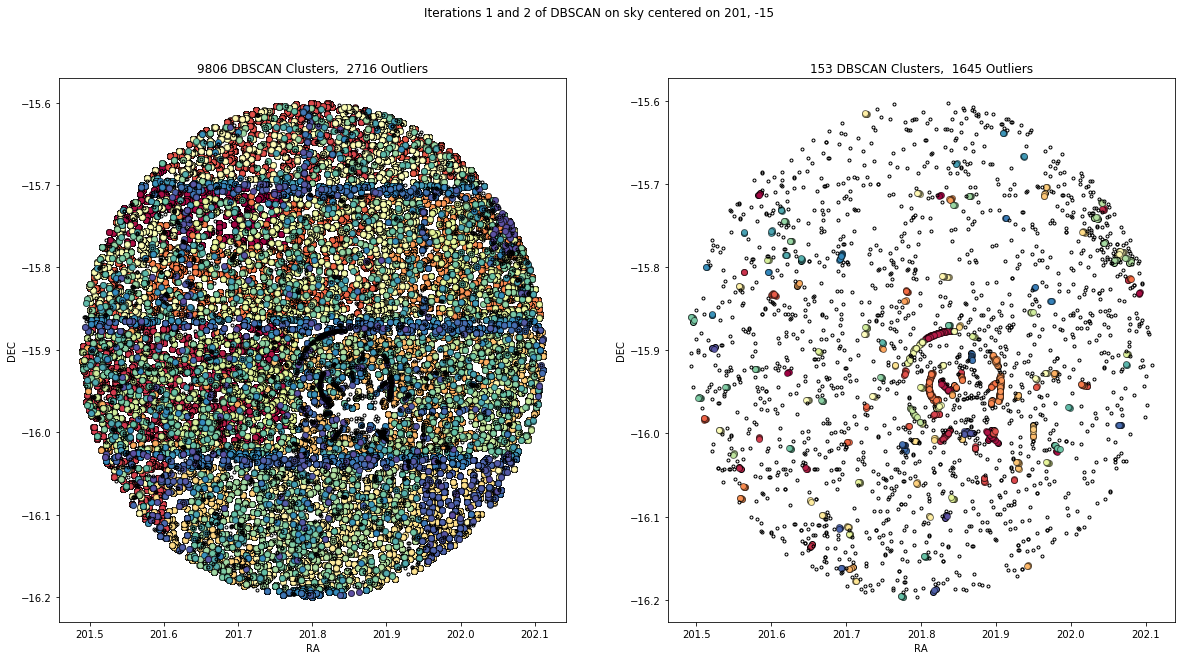

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

CPU times: user 2min 7s, sys: 7.78 s, total: 2min 15s
Wall time: 2min 15s


In [11]:
%%time
#plot DBSCAN on all measurements, and DBSCAN on outliers
f,(ax1,ax2)= plt.subplots(1, 2,figsize=(20,10)) 
f.suptitle('Iterations 1 and 2 of DBSCAN on sky centered on %d, %d' % (RA,DEC))
plot_dbscan(X,db_1,ax1)
plot_dbscan(X_out,db_2,ax2)
plt.show()

#### What is it???